In [2]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 35.9 MB/s 
     |████████████████████████████████| 6.6 MB 59.3 MB/s 
     |████████████████████████████████| 101 kB 13.2 MB/s 
     |████████████████████████████████| 596 kB 69.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


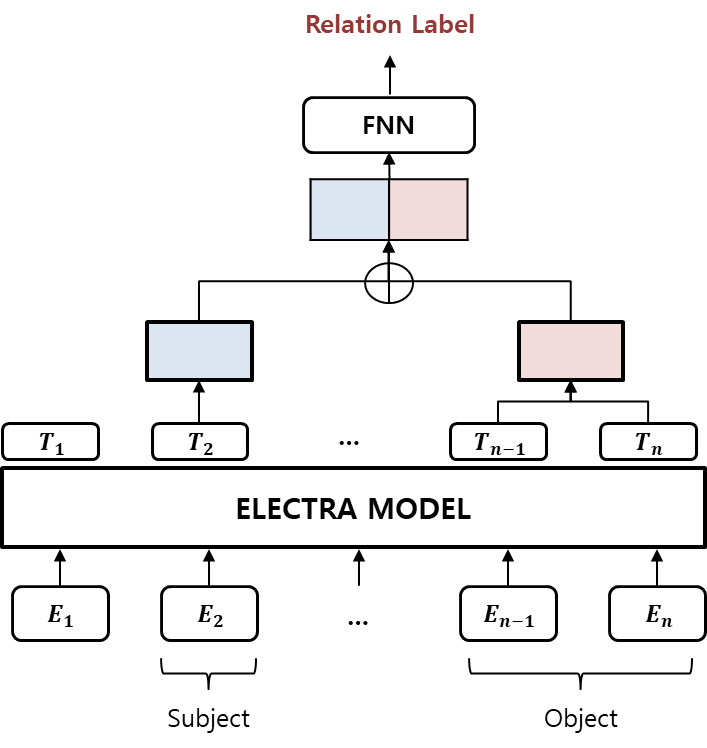

In [14]:
from IPython.display import Image
import os

root_dir = "/gdrive/MyDrive/RelationExtraction"
Image(os.path.join(root_dir, "RelationExtraction.png"))

In [12]:
import json
import torch
from tqdm import tqdm
from transformers import ElectraTokenizer, ElectraPreTrainedModel, ElectraModel, ElectraConfig
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from sklearn.metrics import f1_score

In [15]:
class ElectraForRelationExtraction(ElectraPreTrainedModel):
    def __init__(self, config):
        super(ElectraForRelationExtraction, self).__init__(config)

        # 분류해야할 라벨 수
        self.num_labels = config.num_labels

        # ELECTRA 모델 선언
        self.electra = ElectraModel(config)

        # 최종 출력
        self.re_outputs = nn.Linear(config.hidden_size*2, config.num_labels)

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            subj_masks=None,
            obj_masks=None,
            labels=None
    ):
        # input_ids : [batch, max_length] => [1, 5, 3, 4,78, 345, 234, 67, ... ]
        # attention_mask : [batch, max_length] => [1, 1, 1, 1, 1, 1, 1, 1, ..., 0, 0, 0, 0]
        # subj_masks : [batch, max_length] => [0, 0, 1, 1, 0, 0, 0, 0 ..., 0, 0, 0, 0]
        # obj_masks : [batch, max_length] => [0, 0, 0, 0, 0, 1, 1 ..., 0, 0, 0, 0]
        # labels : [batch] => 4
        
        outputs = self.electra(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        sequence_outputs = outputs[0]
        # (batch, seq_len, hidden)

        subj_outputs = sequence_outputs*subj_masks.unsqueeze(-1)
        # (batch, seq_len, hidden)
        obj_outputs = sequence_outputs*obj_masks.unsqueeze(-1)
        # (batch, seq_len, hidden)

        subj_outputs = torch.sum(subj_outputs, 1)
        # (batch, seq_len, hidden) ==> (batch, hidden)
        obj_outputs = torch.sum(obj_outputs, 1)
        # (batch, seq_len, hidden) ==> (batch, hidden)

        relation_outputs = torch.cat([subj_outputs, obj_outputs], -1)
        # (batch, hidden*2)
        
        relation_logits = self.re_outputs(relation_outputs)
        # (batch, hidden*2) ==> (batch, num_of_labels)

        return relation_logits

<h1>데이터 읽고 전처리 하기</h1>

<pre>
<b>1. tokenize(tokenizer, sentence, subj_text, obj_text, max_length=250)</b>
  자연어 문장을 tokenize하고 Subject와 Object의 위치를 찾기 위한 함수
  
  tokenize(tokenizer, sentence, subj_text, obj_text, max_length=250)
  args
    tokenizer
    sentence : 입력 데이터
      예시) 20대 남성 A(26)씨가 아버지 치료비를 위해 B(30)씨가 모아둔 돈을...
    subj_text : subject 어휘
      예시) A(26)씨
    obj_text : object 어휘
      예시) B(30)씨
    max_length : 문장 최대 길이 (Default 250)
  return
    input_ids, attention_mask, subj_mask, obj_mask

    예시)
      input_ids : [1, 64, 23, 632, ...]
      attention_mask : [1, 1, 1, 1, 1, ..., 0, 0]
      subj_mask : [0, 0, 1, 1, 1, 0, 0, 0, ..., 0, 0]
      Obj_mask : [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..., 0, 0]
      
<b>2. load_data(tokenizer, f_name) </b>
  f_name.txt 파일을 읽고 각 데이터를 읽어 tensor 형태로 변환하기 위한 함수

  args
    tokenizer
    f_name : 전처리하기 위한 데이터가 저장된 파일
   
  return
    TensorDataset(input_ids, attention_masks, subj_masks, obj_masks, labels)

In [ ]:
label2idx = {}
idx2label = {}

# 데이터를 입력받아 tokenize하기 위한 함수
def tokenize(tokenizer, sentence, subj_text, obj_text, max_length=250):
  # 입력 문장 tokenize
  sentence_tokens = tokenizer.tokenize(sentence)

  seq_len = len(sentence_tokens)

  # 입력 문장에서 subject text masking
  subj_masked_sentence = sentence.replace(subj_text, "[MASK]")

  # 입력 문장에서 object text masking
  obj_masked_sentence = sentence.replace(obj_text, "[MASK]")

  subj_tokens = tokenizer.tokenize(subj_text)
  obj_tokens = tokenizer.tokenize(obj_text)

  # 입력 문장에서 masking 위치를 찾아 Subject 위치 탐색
  subj_start = tokenizer.tokenize(subj_masked_sentence).index("[MASK]")
  subj_end = subj_start + len(subj_tokens) - 1

  # 입력 문장에서 masking 위치를 찾아 Object 위치 탐색
  obj_start = tokenizer.tokenize(obj_masked_sentence).index("[MASK]")
  obj_end = obj_start + len(obj_tokens) - 1

  # tokenize된 문장 -> indexing, attention mask, subject위치 mask, object 위치 mask
  input_ids = tokenizer.encode(sentence, max_length=max_length, truncation=True, padding='max_length')
  attention_mask = [1 if e < seq_len else 0 for e in range(max_length)]
  subj_mask = [0 if e < subj_start or e > subj_end else 1 for e in range(max_length)]
  obj_mask = [0 if e < obj_start or e > obj_end else 1 for e in range(max_length)]
  
  return input_ids, attention_mask, subj_mask, obj_mask

# 파일을 읽고 tensor 형태로 변환하기 위한 함수
def load_data(tokenizer, f_name):
  # 입력 문장 index, attention mask, subj mask, obj mask, label 저장을 위한 리스트
  input_ids = []
  attention_masks = []
  subj_masks = []
  obj_masks = []
  labels = []

  with open(f_name,'r',encoding='utf8') as infile:
    data_list = json.load(infile)

    for data in tqdm(data_list):
      sentence = data['sentence']

      subj = data['subject_entity']
      subject_text = subj['word']  
            
      obj = data['object_entity']
      object_text = obj['word']
    
      relation_type = data['label']

      input_idx, attention_mask, subj_mask, obj_mask = \
                 tokenize(tokenizer, sentence, subject_text, object_text)
      

      if relation_type not in label2idx.keys():
        label2idx[relation_type] = len(label2idx)
        idx2label[len(idx2label)] = relation_type
      relation = label2idx[relation_type]

      input_ids.append(input_idx)
      attention_masks.append(attention_mask)
      subj_masks.append(subj_mask)
      obj_masks.append(obj_mask)
      labels.append(relation)
      
    # tensor 형태로 변환
    input_ids = torch.tensor(input_ids, dtype=torch.long)
    attention_masks = torch.tensor(attention_masks, dtype=torch.long)
    subj_masks = torch.tensor(subj_masks, dtype=torch.long)
    obj_masks = torch.tensor(obj_masks, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)
  
  return TensorDataset(input_ids, attention_masks, subj_masks, obj_masks, labels)

In [11]:
def tensor2list(tensor):
    return tensor.detach().cpu().tolist()
    
# 모델의 가중치를 Load하는 부분
def _create_model(config):
    if config["mode"] == "train":
      print("Create Model with Pretrained Parameters...")
    electra_config = ElectraConfig.from_pretrained(
        config["init_weight"] if config["mode"] == "train" else os.path.join(config["output_dir"],
                                                        "checkpoint-{}".format(config["checkpoint"])),
    )
    electra_tokenizer = ElectraTokenizer.from_pretrained(
        config["init_weight"] if config["mode"] == "train" else os.path.join(config["output_dir"],
                                                        "checkpoint-{}".format(config["checkpoint"])),
        do_lower_case=config["do_lower_case"],
    )
    electra_config.num_labels = 30
    model = ElectraForRelationExtraction.from_pretrained(
        config["init_weight"] if config["mode"] == "train" else os.path.join(config["output_dir"],
                                                        "checkpoint-{}".format(config["checkpoint"])),
        config=electra_config
    )
    
    model.cuda()

    return config, model, electra_tokenizer


In [9]:
def train(config, model, tokenizer):
    # 데이터 읽기
    train_dataset = load_data(tokenizer, os.path.join(config["data_dir"], config["train_file"]))

    # TensorDataset/DataLoader를 통해 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
    train_dataloader = DataLoader(train_dataset, shuffle = True, batch_size=config["batch_size"])

    # optimizer 선언
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

    global_step = 0

    # 크로스엔트로피 손실 함수
    loss_func = nn.CrossEntropyLoss()
    best_f1 = 0
    
    for epoch in range(config["num_epochs"]):
        for step, batch in enumerate(train_dataloader):
            # 학습 모드 셋팅
            model.train()

            # .cuda()를 통해 데이터를 메모리에 업로드
            batch = tuple(t.cuda() for t in batch)
            input_ids, attention_mask, subj_masks, obj_masks, labels = batch
            
            hypothesis = model(input_ids, attention_mask, subj_masks, obj_masks, labels)
            # hypothesis : [batch, num_of_labels]

            # Loss 계산 및 역전파
            loss = loss_func(hypothesis, labels)

            loss.backward()

            optimizer.step()
            model.zero_grad()
            global_step += 1

            # 중간 결과 출력
            if global_step % 50 == 0:
                print("{} step Current Loss : {}".format(global_step, loss.item()))

            # 특정 checkpoint 마다 저장 및 평가
            if global_step % 500 == 0:
                cur_f1 = evaluate(config, model, tokenizer)

                if cur_f1 > best_f1:
                    best_f1 = cur_f1

                    # 모델 저장을 위한 부분
                    output_dir = os.path.join(config["output_dir"], "checkpoint-{}".format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)

                    # 모델 및 vocab 저장
                    model.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(model.state_dict, os.path.join(output_dir, "training_args.bin"))
                    print("Saving model checkpoint to ", output_dir)
def evaluate(config, model, tokenizer):
    # 데이터 읽기
    test_dataset = load_data(tokenizer, os.path.join(config["data_dir"], config["test_file"]))

    # TensorDataset/DataLoader를 통해 배치(batch) 단위로 데이터를 분할
    test_dataloader = DataLoader(test_dataset, shuffle = False, batch_size=config["batch_size"])
    predicts = []
    answers = []
    for step, batch in enumerate(test_dataloader):
      # 평가 모드 셋팅
      model.eval()

      # .cuda()를 통해 데이터를 메모리에 업로드
      batch = tuple(t.cuda() for t in batch)
      input_ids, attention_mask, subj_masks, obj_masks, labels = batch

      hypothesis = model(input_ids, attention_mask, subj_masks, obj_masks)
      # hypothesis : [batch, num_of_labels]

      predict_labels = tensor2list(torch.argmax(hypothesis, dim=-1))
      answer = tensor2list(labels)

      predicts += predict_labels
      answers += answer
    f1 = f1_score(answers, predicts, average='micro')
    print("F1 Score : ", f1)
    return f1

In [10]:
if __name__ == "__main__":
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    config = {
        "mode": "test",
        "data_dir": root_dir,
        "output_dir": output_dir,
        "train_file": "klue-re-v1.1_train.json",
        "test_file": "klue-re-v1.1_dev.json",
        "init_weight": "monologg/koelectra-small-v3-discriminator",
        "do_lower_case": False,
        "checkpoint": 3000,
        "batch_size": 32,
        "num_epochs": 5,
        "learning_rate": 5e-5,
    }
    config, model, tokenizer = _create_model(config)

    if config["mode"] == 'train':
      train(config, model, tokenizer)
    elif config["mode"] == 'test':
      evaluate(config, model, tokenizer)

Create Model with Pretrained Parameters...


100%|██████████| 7765/7765 [00:16<00:00, 467.92it/s]


F1 Score :  0.6696716033483581
